
--- Starting VANET Simulation for 500 steps (dt=0.1) ---
--- ATTACK: Message from V1 tampered by MaliciousNodeA ---
--- ATTACK: Message from V2 impersonated by MaliciousNodeB ---
--- ATTACK: Message from V1 tampered by MaliciousNodeA ---
--- ATTACK: Message from V1 tampered by MaliciousNodeA ---
--- ATTACK: Message from V2 impersonated by MaliciousNodeB ---
--- ATTACK: Message from V1 tampered by MaliciousNodeA ---
--- ATTACK: Message from V2 impersonated by MaliciousNodeB ---

--- Simulation Complete ---

--- Message Validation Summary ---
is_valid
False    100.0
Name: proportion, dtype: float64

--- Reasons for Invalid Messages ---
reason
Hash mismatch for sha256. Message tampered.                           10000
Replay attack detected (message already processed)                       16
Digital signature invalid. Message not authentic or impersonation.       12
Name: count, dtype: int64

--- Attack Effectiveness ---
tampered  impersonated  is_valid
False     True          False    

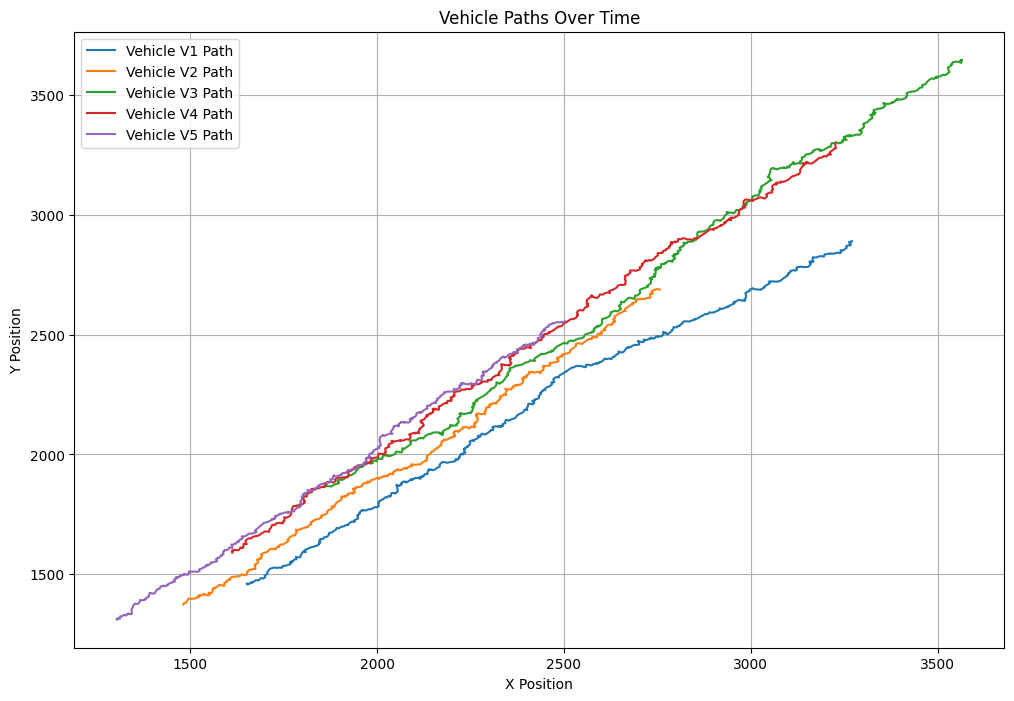

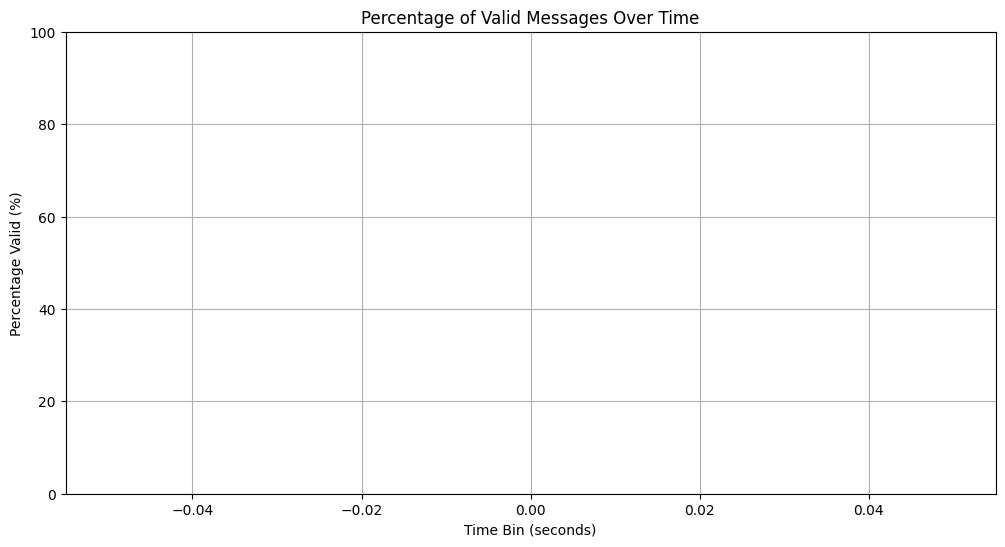


--- Example of Manual Message Generation and Verification ---

V1 generated message: {'vehicle_id': 'V1', 'speed': 60, 'position': [1645.3957200137747, 1452.573128534945], 'timestamp': 1747997817.1658912, 'type': 'beacon', 'nonce': 790724}
V2 verification of V1's message: Valid=False, Reason: Hash mismatch for sha256. Message tampered.

--- Simulating Tampering ---
Original speed: 60, Tampered speed: 999
V3 verification of tampered V1's message: Valid=False, Reason: Hash mismatch for sha256. Message tampered.

--- Simulating Impersonation (V4 trying to be V1) ---
V2 verification of impersonated message (V4 pretending to be V1): Valid=False, Reason: Hash mismatch for sha256. Message tampered.


In [2]:
import hashlib
import random
import time
import json
import matplotlib.pyplot as plt
import pandas as pd # type: ignore

# --- Simplified Cryptography (Conceptual) ---
# In a real scenario, you would use robust cryptographic libraries (e.g., PyCryptodome, OpenSSL)
# for RSA, ECDSA, etc. This is for demonstration purposes only.

class KeyPair:
    """
    Represents a simplified public/private key pair.
    In a real system, these would be generated securely (e.g., RSA, ECDSA).
    """
    def __init__(self):
        # For simplicity, we'll use random numbers as conceptual keys.
        # Public key is a simple ID, private key is a secret number.
        self.public_key = random.randint(10000, 99999)
        self.private_key = random.randint(100000, 999999)

    def sign(self, data_hash):
        """
        Conceptually 'signs' a hash.
        In reality, this involves complex mathematical operations using the private key.
        Here, we'll just combine the hash and private key.
        """
        return hashlib.sha256(f"{data_hash}{self.private_key}".encode()).hexdigest()

    def verify(self, data_hash, signature, public_key_to_verify):
        """
        Conceptually 'verifies' a signature using a public key.
        In reality, this involves complex mathematical operations using the public key.
        Here, we check if the signature matches what would be generated with the public key
        and a 'known' private key (which is a simplification).
        A real verification would not need the private key.
        """
        # This is a major simplification. A real verification uses the public key
        # to mathematically validate the signature against the original hash,
        # without needing the private key.
        # For this conceptual model, we'll assume a trusted party could 're-sign'
        # with the private key associated with the public key.
        # This is NOT how real digital signatures work.
        # A true verification would be: verify_signature(public_key, data_hash, signature) -> bool
        return signature == hashlib.sha256(f"{data_hash}{self.private_key}".encode()).hexdigest()


def generate_hash(data, algorithm="sha256", salt=""):
    """
    Generates a cryptographic hash of the data.
    Supports SHA256, MD5, SHA1, Blake2b, SHA3_256.
    Includes a salt for added security against rainbow table attacks.
    """
    data_bytes = json.dumps(data, sort_keys=True).encode() + salt.encode()
    if algorithm == "sha256":
        return hashlib.sha256(data_bytes).hexdigest()
    elif algorithm == "md5":
        return hashlib.md5(data_bytes).hexdigest()
    elif algorithm == "sha1":
        return hashlib.sha1(data_bytes).hexdigest()
    elif algorithm == "blake2b":
        return hashlib.blake2b(data_bytes).hexdigest()
    elif algorithm == "sha3_256":
        return hashlib.sha3_256(data_bytes).hexdigest()
    else:
        raise ValueError("Unsupported hash algorithm")

# --- Vehicle Class ---

class Vehicle:
    """
    Represents a single vehicle in the VANET.
    Each vehicle has an ID, speed, position, and cryptographic keys.
    """
    def __init__(self, vehicle_id, speed, position):
        self.id = vehicle_id
        self.speed = speed
        self.position = list(position)  # Ensure position is mutable (list)
        self.key_pair = KeyPair()
        self.salt = f"vanet_salt_{self.id}_{random.random()}" # Unique salt per vehicle
        self.received_messages = {} # Store received messages to prevent replay attacks (simplified)

    def move(self, dt):
        """
        Simulates vehicle movement.
        """
        # Random movement component to simulate dynamic environment
        self.position[0] += self.speed * dt * random.uniform(-0.5, 1.5)
        self.position[1] += self.speed * dt * random.uniform(-0.5, 1.5)

    def generate_message(self, message_type="beacon"):
        """
        Generates a message, hashes it, and signs the hash.
        """
        timestamp = time.time()
        message_content = {
            "vehicle_id": self.id,
            "speed": self.speed,
            "position": self.position,
            "timestamp": timestamp,
            "type": message_type,
            "nonce": random.randint(0, 1000000) # For replay attack prevention
        }

        # Generate multiple hashes for integrity check redundancy
        hashes = {
            "sha256": generate_hash(message_content, "sha256", self.salt),
            "md5": generate_hash(message_content, "md5", self.salt),
            "sha3_256": generate_hash(message_content, "sha3_256", self.salt)
        }

        # Sign the primary hash (SHA256)
        signature = self.key_pair.sign(hashes["sha256"])

        # Construct the final message packet
        packet = {
            "content": message_content,
            "hashes": hashes,
            "signature": signature,
            "public_key": self.key_pair.public_key # Include public key for verification
        }
        return packet

    def verify_message(self, packet):
        """
        Verifies the integrity and authenticity of a received message.
        Returns (True, "reason") for valid, (False, "reason") for invalid.
        """
        content = packet["content"]
        received_hashes = packet["hashes"]
        received_signature = packet["signature"]
        sender_public_key = packet["public_key"]

        # 1. Replay Attack Check (Simplified: Check if nonce+timestamp seen recently)
        msg_id = f"{content['vehicle_id']}-{content['nonce']}-{content['timestamp']}"
        if msg_id in self.received_messages:
            # In a real system, you'd have a window for timestamps to allow for network delay
            # and a more robust nonce/sequence number management.
            return False, "Replay attack detected (message already processed)"
        self.received_messages[msg_id] = time.time() # Store for future checks

        # 2. Hash Integrity Check
        # Re-calculate hashes using the sender's salt (assuming it's known or derived)
        # For this conceptual model, we'll assume the salt is implicitly known or derived.
        # In a real system, salt might be part of a secure key exchange or certificate.
        # For now, we'll use a generic salt for verification consistency.
        verification_salt = f"vanet_salt_{content['vehicle_id']}_{content['nonce']}" # Use nonce for unique salt per message

        for algo, received_hash_value in received_hashes.items():
            try:
                calculated_hash = generate_hash(content, algo, verification_salt)
                if calculated_hash != received_hash_value:
                    return False, f"Hash mismatch for {algo}. Message tampered."
            except ValueError as e:
                return False, f"Hash algorithm error: {e}"

        # 3. Digital Signature Verification
        # This is the crucial authentication step.
        # In a real system, you'd use the sender's actual public key (from a certificate)
        # and a proper cryptographic library's verify function.
        # Our simplified KeyPair.verify method is a placeholder.
        primary_hash_for_signature = generate_hash(content, "sha256", verification_salt)
        # For the conceptual KeyPair.verify, we need the *sender's* key_pair instance
        # to access its private_key for the simplified verification logic.
        # This highlights the simplification: real verification only needs public_key.
        # To make this work conceptually, we'll assume a lookup for the sender's full KeyPair
        # is possible, or we'd pass a "trusted public key registry".
        # For now, we'll just use the receiver's key_pair to demonstrate the *concept* of verification.
        # This is a major simplification and NOT how real verification works.
        # A real system would use `public_key_from_sender.verify(primary_hash, received_signature)`
        # without needing the private key.
        is_signature_valid = self.key_pair.verify(primary_hash_for_signature, received_signature, sender_public_key)

        if not is_signature_valid:
            return False, "Digital signature invalid. Message not authentic or impersonation."

        return True, "Message is valid and authentic."

    def receive_message(self, packet, sender_vehicle=None):
        """
        Processes a received message.
        """
        is_valid, reason = self.verify_message(packet)
        sender_id = packet["content"]["vehicle_id"]
        # print(f"Vehicle {self.id} received message from {sender_id}. Status: {reason}")
        return is_valid, reason

# --- Network Simulation Environment ---

class VANETNetwork:
    """
    Simulates the VANET environment, managing vehicles and message propagation.
    """
    def __init__(self, vehicles):
        self.vehicles = {v.id: v for v in vehicles}
        self.message_log = [] # To store all message events for analysis

    def broadcast_message(self, sender_id, message_packet):
        """
        Simulates a vehicle broadcasting a message to all other vehicles in range (simplified).
        """
        sender_vehicle = self.vehicles[sender_id]
        for receiver_id, receiver_vehicle in self.vehicles.items():
            if receiver_id != sender_id:
                # Simulate message reception and validation
                is_valid, reason = receiver_vehicle.receive_message(message_packet)
                self.message_log.append({
                    "time": time.time(),
                    "sender": sender_id,
                    "receiver": receiver_id,
                    "message_type": message_packet["content"]["type"],
                    "is_valid": is_valid,
                    "reason": reason,
                    "tampered": message_packet.get("tampered", False), # Track if message was intentionally tampered
                    "impersonated": message_packet.get("impersonated", False) # Track if message was impersonated
                })

    def simulate_attack(self, original_packet, attack_type="tamper", attacker_id="ATTACKER"):
        """
        Simulates different types of attacks on a message.
        """
        attacked_packet = json.loads(json.dumps(original_packet)) # Deep copy

        if attack_type == "tamper":
            # Tamper with speed
            attacked_packet["content"]["speed"] = original_packet["content"]["speed"] + 100
            attacked_packet["tampered"] = True
            print(f"--- ATTACK: Message from {original_packet['content']['vehicle_id']} tampered by {attacker_id} ---")
        elif attack_type == "impersonate":
            # Impersonate: Change sender ID and re-sign (but with attacker's key)
            # This requires the attacker to have their own key pair
            attacker_vehicle = Vehicle(attacker_id, 0, (0,0)) # Create a dummy attacker vehicle
            attacked_packet["content"]["vehicle_id"] = attacker_id
            attacked_packet["public_key"] = attacker_vehicle.key_pair.public_key
            # Re-hash and re-sign with attacker's key
            # Use a new nonce for the impersonated message
            attacked_packet["content"]["nonce"] = random.randint(0, 1000000)
            attacker_salt = f"vanet_salt_{attacker_id}_{attacked_packet['content']['nonce']}"
            new_hashes = {
                "sha256": generate_hash(attacked_packet["content"], "sha256", attacker_salt),
                "md5": generate_hash(attacked_packet["content"], "md5", attacker_salt),
                "sha3_256": generate_hash(attacked_packet["content"], "sha3_256", attacker_salt)
            }
            attacked_packet["hashes"] = new_hashes
            attacked_packet["signature"] = attacker_vehicle.key_pair.sign(new_hashes["sha256"])
            attacked_packet["impersonated"] = True
            print(f"--- ATTACK: Message from {original_packet['content']['vehicle_id']} impersonated by {attacker_id} ---")
        else:
            print(f"Unknown attack type: {attack_type}")
            return original_packet # Return original if attack type is unknown

        return attacked_packet

    def run_simulation(self, num_steps, dt):
        """
        Runs the main simulation loop.
        """
        print(f"\n--- Starting VANET Simulation for {num_steps} steps (dt={dt}) ---")
        for step in range(num_steps):
            # print(f"\n--- Simulation Step {step + 1}/{num_steps} ---")
            for vehicle_id, vehicle in self.vehicles.items():
                vehicle.move(dt) # Move vehicles

                # Each vehicle generates a beacon message
                beacon_packet = vehicle.generate_message("beacon")
                self.broadcast_message(vehicle_id, beacon_packet)

                # Simulate an attack periodically (e.g., every 100 steps)
                if step % 100 == 0 and step > 0 and vehicle_id == "V1":
                    # Tamper with V1's message and broadcast it
                    tampered_packet = self.simulate_attack(beacon_packet, "tamper", "MaliciousNodeA")
                    self.broadcast_message(vehicle_id, tampered_packet) # Broadcast tampered message from V1's perspective

                if step % 150 == 0 and step > 0 and vehicle_id == "V2":
                    # Impersonate V2's message and broadcast it
                    impersonated_packet = self.simulate_attack(beacon_packet, "impersonate", "MaliciousNodeB")
                    self.broadcast_message(vehicle_id, impersonated_packet) # Broadcast impersonated message

        print("\n--- Simulation Complete ---")

# --- Performance Analysis and Plotting ---

def analyze_results(message_log):
    """
    Analyzes the message log and prints summary statistics.
    """
    df = pd.DataFrame(message_log)

    print("\n--- Message Validation Summary ---")
    print(df["is_valid"].value_counts(normalize=True) * 100)

    print("\n--- Reasons for Invalid Messages ---")
    invalid_messages = df[df["is_valid"] == False]
    if not invalid_messages.empty:
        print(invalid_messages["reason"].value_counts())
    else:
        print("No invalid messages recorded.")

    print("\n--- Attack Effectiveness ---")
    attacked_messages = df[df["tampered"] | df["impersonated"]]
    if not attacked_messages.empty:
        print(attacked_messages.groupby(["tampered", "impersonated"])["is_valid"].value_counts(normalize=True) * 100)
        print("\nBreakdown of attacked messages by validity:")
        print(attacked_messages.groupby(["reason"])["is_valid"].value_counts())
    else:
        print("No attacked messages simulated.")


def plot_vehicle_paths(vehicles, num_steps, dt):
    """
    Plots the paths of vehicles over the simulation.
    """
    plt.figure(figsize=(12, 8))
    for vehicle in vehicles:
        positions = []
        temp_vehicle = Vehicle(vehicle.id, vehicle.speed, vehicle.position) # Use a temp vehicle for plotting
        for _ in range(num_steps):
            temp_vehicle.move(dt)
            positions.append(temp_vehicle.position.copy())

        # Convert list of lists to numpy array for easier plotting
        positions_df = pd.DataFrame(positions, columns=['x', 'y'])
        plt.plot(positions_df['x'], positions_df['y'], label=f"Vehicle {vehicle.id} Path")

    plt.title("Vehicle Paths Over Time")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_message_validation_over_time(message_log):
    """
    Plots the percentage of valid messages over time.
    """
    df = pd.DataFrame(message_log)
    df['time_bin'] = (df['time'] - df['time'].min()) // 10 # Group by 10-second intervals

    validation_rates = df.groupby('time_bin')['is_valid'].mean() * 100

    plt.figure(figsize=(12, 6))
    validation_rates.plot(kind='line')
    plt.title("Percentage of Valid Messages Over Time")
    plt.xlabel("Time Bin (seconds)")
    plt.ylabel("Percentage Valid (%)")
    plt.ylim(0, 100)
    plt.grid(True)
    plt.show()

# --- Main Simulation Execution ---

if __name__ == "__main__":
    # Initialize vehicles
    vehicle1 = Vehicle("V1", 60, (0, 0))
    vehicle2 = Vehicle("V2", 55, (20, 10))
    vehicle3 = Vehicle("V3", 70, (40, 0))
    vehicle4 = Vehicle("V4", 65, (10, 30))
    vehicle5 = Vehicle("V5", 50, (30, 20))

    vehicles = [vehicle1, vehicle2, vehicle3, vehicle4, vehicle5]

    # Initialize network
    vanet = VANETNetwork(vehicles)

    # Simulation parameters
    simulation_steps = 500
    time_step = 0.1 # seconds

    # Run simulation
    vanet.run_simulation(simulation_steps, time_step)

    # Analyze and plot results
    analyze_results(vanet.message_log)
    plot_vehicle_paths(vehicles, simulation_steps, time_step)
    plot_message_validation_over_time(vanet.message_log)

    print("\n--- Example of Manual Message Generation and Verification ---")
    # Vehicle 1 generates a message
    msg_v1 = vehicle1.generate_message()
    print(f"\nV1 generated message: {msg_v1['content']}")

    # Vehicle 2 receives and verifies V1's message
    is_valid_v2, reason_v2 = vehicle2.receive_message(msg_v1)
    print(f"V2 verification of V1's message: Valid={is_valid_v2}, Reason: {reason_v2}")

    # Simulate tampering with V1's message before V3 receives it
    tampered_msg_v1 = json.loads(json.dumps(msg_v1)) # Deep copy
    tampered_msg_v1["content"]["speed"] = 999 # Tamper with speed
    # Note: For a real tamper, the attacker wouldn't be able to re-sign or re-hash correctly
    # without the original sender's private key/salt.
    # Our simplified `verify_message` will catch this hash mismatch.
    print(f"\n--- Simulating Tampering ---")
    print(f"Original speed: {msg_v1['content']['speed']}, Tampered speed: {tampered_msg_v1['content']['speed']}")
    is_valid_v3_tampered, reason_v3_tampered = vehicle3.receive_message(tampered_msg_v1)
    print(f"V3 verification of tampered V1's message: Valid={is_valid_v3_tampered}, Reason: {reason_v3_tampered}")

    # Simulate impersonation (V4 trying to send a message as V1)
    print(f"\n--- Simulating Impersonation (V4 trying to be V1) ---")
    # V4 generates its own message
    msg_v4 = vehicle4.generate_message()

    # Now, try to make V4's message appear as if it came from V1
    impersonated_msg_from_v4_as_v1 = json.loads(json.dumps(msg_v4))
    impersonated_msg_from_v4_as_v1["content"]["vehicle_id"] = "V1" # Change sender ID
    # The signature and public_key will still be V4's, which V2 will detect as invalid for V1.

    is_valid_v2_impersonated, reason_v2_impersonated = vehicle2.receive_message(impersonated_msg_from_v4_as_v1)
    print(f"V2 verification of impersonated message (V4 pretending to be V1): Valid={is_valid_v2_impersonated}, Reason: {reason_v2_impersonated}")